<a href="https://colab.research.google.com/github/khanma1962/Fire_Detection_Faster_RCNN/blob/main/Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection Using Faster R-CNN

# Paper Referred

https://arxiv.org/pdf/1506.01497.pdf

### Github Repository
https://github.com/pytorch/vision/tree/master/references/detection

### Faster R-CNN Tutorial from
https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

https://www.kaggle.com/moekhan/pytorch-starter-fasterrcnn-train/edit

https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py

# Labelling Tools used
https://github.com/tzutalin/labelImg

# Neural Network Traing Strategy
http://karpathy.github.io/2019/04/25/recipe/





In [1]:
!python --version

Python 3.7.11


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calling Libraries

In [3]:
# clone the torchvision libraries
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 31928, done.
remote: Counting objects: 100% (4471/4471), done.
remote: Compressing objects: 100% (971/971), done.
remote: Total 31928 (delta 3550), reused 4271 (delta 3413), pack-reused 27457
Receiving objects: 100% (31928/31928), 39.01 MiB | 25.66 MiB/s, done.
Resolving deltas: 100% (24160/24160), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [4]:
# Calling all the libraries
import numpy as np
import pandas as pd
import torch
import torchvision 
from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
# from torchvision import engine
import engine

torch.manual_seed(42)


In [5]:
# checking for cuda
if (torch.cuda.is_available()):
    device = torch.device('cuda')
    print(f'device is {device} and device name is {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print(f'Connected to {str(device).upper()}')


device is cuda and device name is Tesla V100-SXM2-16GB


In [6]:
!nvidia-smi

Sat Jul 24 19:22:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset

In [10]:
# copy google drive files to colab directories
import timeit
start = timeit.timeit()
!rm -r /content/data/
!cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/ .
end = timeit.timeit()
print(f'Total time to transfer data is {end-start}')

main_dir = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System'
train_dir = '/content/data/train/images/'
test_dir  = '/content/data/validation/images/'

#load csv with bounding details into pandas
train_df = pd.read_csv('/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/train/myvisionai_7_24_21_tr.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/validation/myvisionai_7_24_21_val.csv')

print(f"Unique pics in train are {len(train_df['filename'].unique())}")
print(train_df.info(), '\n\n')

print(f"Unique pics in test are {len(test_df['filename'].unique())}")
print(test_df.info())


Total time to transfer data is -0.0007780789997013926
Unique pics in train are 412
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  563 non-null    object
 1   width     563 non-null    object
 2   height    563 non-null    object
 3   class     563 non-null    object
 4   xmin      563 non-null    int64 
 5   ymin      563 non-null    int64 
 6   xmax      563 non-null    int64 
 7   ymax      563 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 35.3+ KB
None 


Unique pics in test are 90
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  138 non-null    object
 1   width     138 non-null    object
 2   height    138 non-null    object
 3   class     138 non-null    object
 4   xmin      

In [ ]:
#load csv with bounding details into pandas
# train_df = pd.read_csv('/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/train/myvisionai_7_24_21_tr.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/validation/myvisionai_7_24_21_val.csv')

# print(f"Unique pics in train are {len(train_df['filename'].unique())}")
# print(train_df.info(), '\n\n')

# print(f"Unique pics in test are {len(test_df['filename'].unique())}")
# print(test_df.info())

In [11]:
train_dir

'/content/data/train/images/'

In [12]:
# checking number of files in train and test
for path, dir, fils in os.walk(train_dir):
    print(f'{path} has {len(os.listdir(path))}')

for path, dir, fils in os.walk(test_dir):
    print(f'{path} has {len(os.listdir(path))}')
# len(os.listdir(test_dir))

/content/data/train/images/ has 412
/content/data/validation/images/ has 90


Image size is (185, 272, 3)


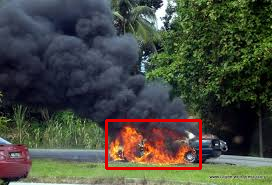

In [13]:
#plot a picture
pic_name = 'img (100).jpg'
image = cv2.imread(train_dir + pic_name)
print(f'Image size is {image.shape}')

xmin = train_df[train_df['filename']== pic_name]['xmin'].values
ymin = train_df[train_df['filename']== pic_name]['ymin'].values
xmax = train_df[train_df['filename']== pic_name]['xmax'].values
ymax = train_df[train_df['filename']== pic_name]['ymax'].values

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(image)


In [17]:
# Creating FireDataseet class
class FireDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms= None):
        super().__init__()

        self.image_ids = dataframe['filename'].unique()
        print(f'self.image_ids is {self.image_ids.shape}')
        self.df = dataframe
        self.image_dir = image_dir
        # print('new',self.image_dir)
        self.transforms = transforms

    def __getitem__(self, index: int):
        # print(f'index is {index} and image_id is {self.image_ids[index]}')
        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]

        # read image into cv2 format
        
        full_filename = f'{self.image_dir}{image_id}'
        image = Image.open(full_filename).convert('RGB')
        
        # image = cv2.imread(full_filename, cv2.IMREAD_COLOR)#Image.open
        # print(f'image_dir is {full_filename}, image_id is {image_id}, image_shape is {image.shape}  ')
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float)
        # image = image / 255.

        # find are based on xmin, ymin, xman, and yman
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # print(f'boxes is {boxes}')
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        # print(f'area is {area}')

        # conver boxes and are into tensors
        
        boxes = torch.as_tensor(boxes, dtype= torch.float32)
        
        area  = torch.as_tensor(area, dtype=torch.float32)

        # there is one class only
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        # print('here')
        labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
        

        # create a dictionary target
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        # print('there')

        # # transforms
        if self.transforms is not None:
            # image, target  = self.transforms(image, target)
            image  = self.transforms(image)
            # image = torchvision.transforms.ToTensor()(image)

        return image, target

    def __len__(self) -> int:
        # return self.image_ids.shape[0]
        return 10 # returns only 10 images - use it for overfitting the model



In [18]:

batch_size = 2
img_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# collate function
# each element of dataset returns tupe(image, target) instead of a single value

def collate_function(batch):
    return tuple(zip(*batch))

def get_transform(train):
    transforms = []
    # conver PIL to Tensor
    transforms.append(T.ToTensor())
    if train:
        # flip images during training 
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# train and test datasets
train_dataset = FireDataset(train_df, train_dir, get_transform(train=True) )
test_dataset  = FireDataset(test_df, test_dir, get_transform(train=False) )

#train and test dataloader
train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers =0,
                               collate_fn = collate_function)

test_data_loader = DataLoader(test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers =2,
                               collate_fn = collate_function)


self.image_ids is (412,)
self.image_ids is (90,)


In [19]:
for images, targets in train_data_loader:
    break
print(f'image.shape is {images[0].shape}\n')
print(f'targets are {targets}')

image.shape is torch.Size([3, 199, 253])

targets are ({'boxes': tensor([[107., 100., 170., 135.]]), 'labels': tensor([1]), 'image_id': tensor([8]), 'area': tensor([2205.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[ 5., 40., 81., 95.]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([4180.]), 'iscrowd': tensor([0])})


image.shape is torch.Size([3, 183, 275])


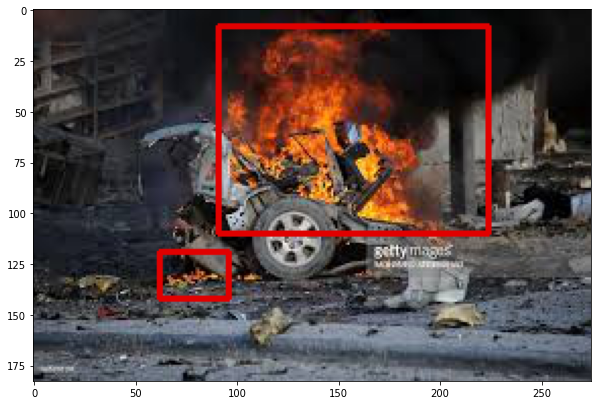

In [22]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1, 2, 0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_image(data, idx):
    out = data.__getitem__(idx)
    print(f"image.shape is {out[0].shape}")
    image = image_convert(out[0])
    image = np.ascontiguousarray(image) # returns ndarray contiguous
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (i[0], i[1]), (i[2], i[3]), (225, 0 ,0), thickness=2)
    
    plt.figure(figsize=(10,10))
    plt.imshow(image)

plot_image(train_dataset, 101)


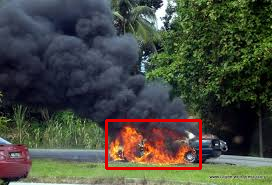

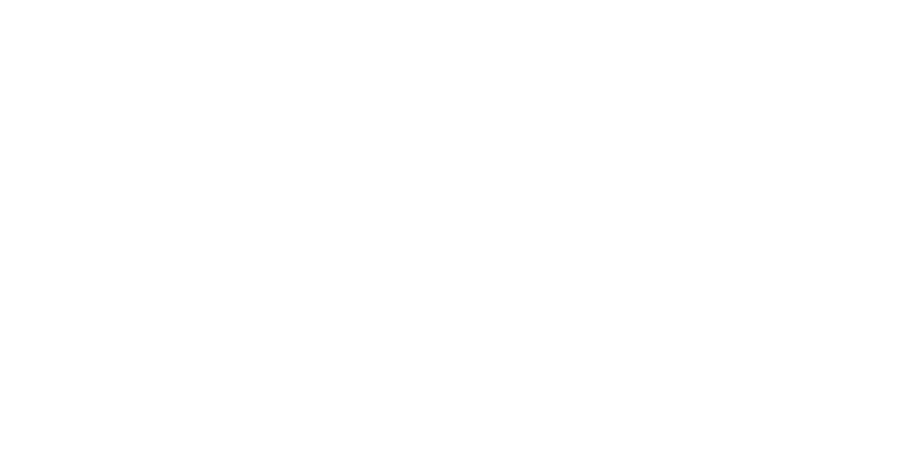

In [23]:
# let's see some images
# read first batch from train_data_loader
images, targets = next(iter(train_data_loader))

#send image to device
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1, 2, 0).cpu().numpy() # permute rearrange to 1,2,0 axis

fig, ax = plt.subplots(1, 1, figsize=(16,8))

for box in boxes:
    cv2.rectangle(img,
                 (box[0], box[1]),
                 (box[2], box[3]),
                 (0, 0, 225),
                  3)
ax.set_axis_off()
# ax.imshow(img)

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
# image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(image);


# Pre-trained Model from torchvision


In [24]:
#Fine Tuning Pre-Trained Model
#load a pre-trained model with resnet50 as backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one
num_classes = 2 # 1 class(fire) and 0(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head wit the new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


# Train

In [25]:
# Training parameters
num_epochs = 100

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.006, momentum = 0.9, weight_decay= 0.006)
lr_scheduler = None
itr = 1


for epoch in range(num_epochs):
    
    for images, targets in train_data_loader:
        
        #send images and targets to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]


        loss_dict = model(images, targets)
        # print(f'loss dict is {loss_dict}')
        losses = sum(loss for loss in loss_dict.values())
        # print(f'losses are {losses} ')
        loss_value = losses.item()

        optimizer.zero_grad() # to clear old gradient to zero
        losses.backward() # back prop for required_grade = True
        optimizer.step() # update parameter based on parameter.grad

        if itr % 20 == 0:
            print(f'Iterattion #{iter}  loss: {loss_value}')

        itr += 1
        if lr_scheduler is not None:
            lr_scheduler.step() # for adjusting the learning rate

    print(f'Epoch #{epoch+1} loss: {loss_value}')

    # evaluate(model, test_data_loader, device=device )

# save model    
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')




/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch #1 loss: 0.385511189699173
Epoch #2 loss: 0.31018343567848206
Epoch #3 loss: 0.22019639611244202
Iterattion #<built-in function iter>  loss: 0.21046404540538788
Epoch #4 loss: 0.21046404540538788
Epoch #5 loss: 0.16824807226657867
Epoch #6 loss: 0.20039579272270203
Epoch #7 loss: 0.14573678374290466
Iterattion #<built-in function iter>  loss: 0.14201129972934723
Epoch #8 loss: 0.14201129972934723
Epoch #9 loss: 0.2007402628660202
Epoch #10 loss: 0.16791413724422455
Epoch #11 loss: 0.12983521819114685
Iterattion #<built-in function iter>  loss: 0.228949636220932
Epoch #12 loss: 0.228949636220932
Epoch #13 loss: 0.10178960114717484
Epoch #14 loss: 0.15514110028743744
Epoch #15 loss: 0.10866711288690567
Iterattion #<built-in function iter>  loss: 0.07220124453306198
Epoch #16 loss: 0.07220124453306198
Epoch #17 loss: 0.1593456119298935
Epoch #18 loss: 0.07883376628160477
Epoch #19 loss: 0.11313045769929886
Iterattion #<built-in function iter>  loss: 0.10730623453855515
Epoch #20 los

NameError: ignored

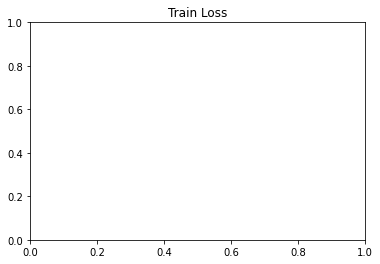

In [26]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.show()

# Validation

In [ ]:
plot_image(test_dataset, 3)

In [ ]:
# load the data loader
images, targets  = next(iter(test_data_loader)) # test_data_loader

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1, 2, 0).cpu().numpy() # permute re-arrange the axes

fig, ax = plt.subplots(1, 1, figsize = (16,8))

for box in boxes:
    cv2.rectangle(img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 225),
                  3
                  )

ax.set_axis_off()

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
# image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(image);
